# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Исследовать данные и сделайте выводы по полученным результатам. Подкрепить рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе анализа необходимо:
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на **ключевые вопросы HR-агентства**:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Отметить другие интересные закономерности в данных.

## <center> 1.1 Загрузка и обработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data = data.drop(['Unnamed: 0'], axis=1) # удаляем ненужный признаки "Unnamed: 0"
data.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


условия задачи или требования HR агества не установили условия **уровня значимости**, в таком случае по умолчанию принимаем alpha = 0.05

In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## <center> 1.2 Предварительный Анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


В датасете 606 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


## <center> 1.3 Обработка данных

Удалим дублирующие и не нужные признаки (salary, salary_currency), заработные платы уже приведены к одной валюте "salary_in_usd"

In [6]:
# Удаляем ненужные признаки
data = data.drop(['salary', 'salary_currency'], axis=1)
data.head(3) 

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M


Следующие признаки переведены в "категориальные":

In [7]:
data['work_year'] = data['work_year'].astype('category')
data['experience_level'] = data['experience_level'].astype('category')
data['employment_type'] = data['employment_type'].astype('category')
data['employee_residence'] = data['employee_residence'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')
data['company_location'] = data['company_location'].astype('category')
data['company_size'] = data['company_size'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    category
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    object  
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(7), int64(1), object(1)
memory usage: 22.8+ KB


Изучим **"job_title"** на количество уникальных позиций

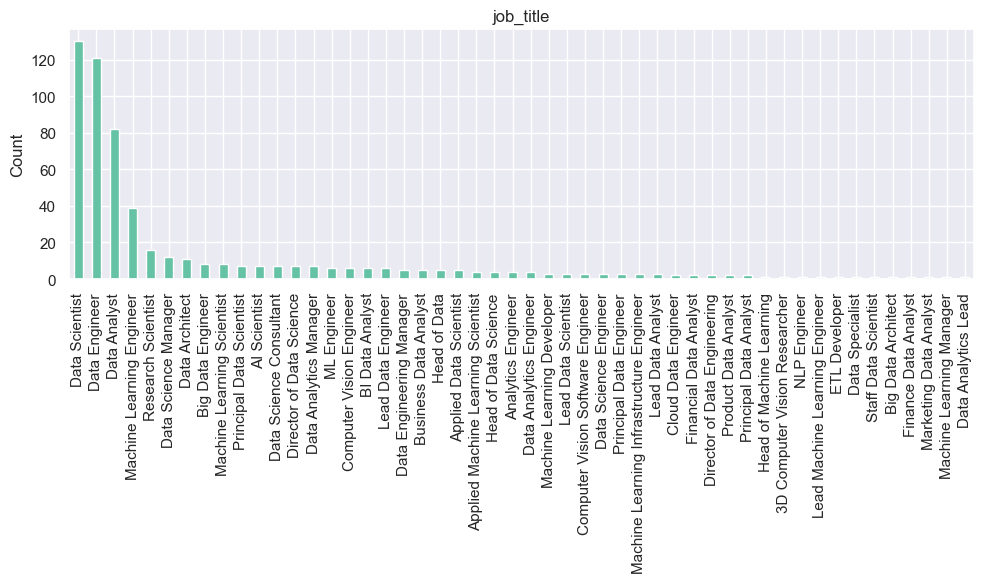

In [8]:
# График распределения для job_title
plt.figure(figsize=(10, 6))
data['job_title'].value_counts().plot(kind='bar')
plt.title('job_title')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Нужно отобрать только позиции по Data Scientist & Data Engineer. Дополнительно, необходимо сделать "Разбор текста" всех остальных должностей на предмет причастности к Data Science или Data Engineer

In [9]:
# Новый признак: содержит job_title 'Data Scientist' или 'Data Science'
data['is_data_scientist'] = data['job_title'].str.contains(r'Data Scientist|Data Science', case=False, na=False)
data['is_data_scientist'].value_counts()

is_data_scientist
False    386
True     179
Name: count, dtype: int64

In [10]:
# Новый признак: содержит job_title 'Data Engineer'
data['is_data_engineer'] = data['job_title'].str.contains(r'Data Engineer', case=False, na=False)
data['is_data_engineer'].value_counts()

is_data_engineer
False    418
True     147
Name: count, dtype: int64

Можно удалить признак **'job_title'** из дата сета. Другие направления/специальности нас пока не интересует, анализ ведется только по специальностям **Data Science & Data Engineer**. Всего осталось 326 позиций из изначальных 606 записей.

In [11]:
# Удаляем признак job_title
# data = data.drop(['job_title'], axis=1)

# Удаляем строки, где не Data Scientist и не Data Engineer
data = data[data['is_data_scientist'] | data['is_data_engineer']]
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           326 non-null    category
 1   experience_level    326 non-null    category
 2   employment_type     326 non-null    category
 3   job_title           326 non-null    object  
 4   salary_in_usd       326 non-null    int64   
 5   employee_residence  326 non-null    category
 6   remote_ratio        326 non-null    category
 7   company_location    326 non-null    category
 8   company_size        326 non-null    category
 9   is_data_scientist   326 non-null    bool    
 10  is_data_engineer    326 non-null    bool    
dtypes: bool(2), category(7), int64(1), object(1)
memory usage: 13.8+ KB


Изучим список стран

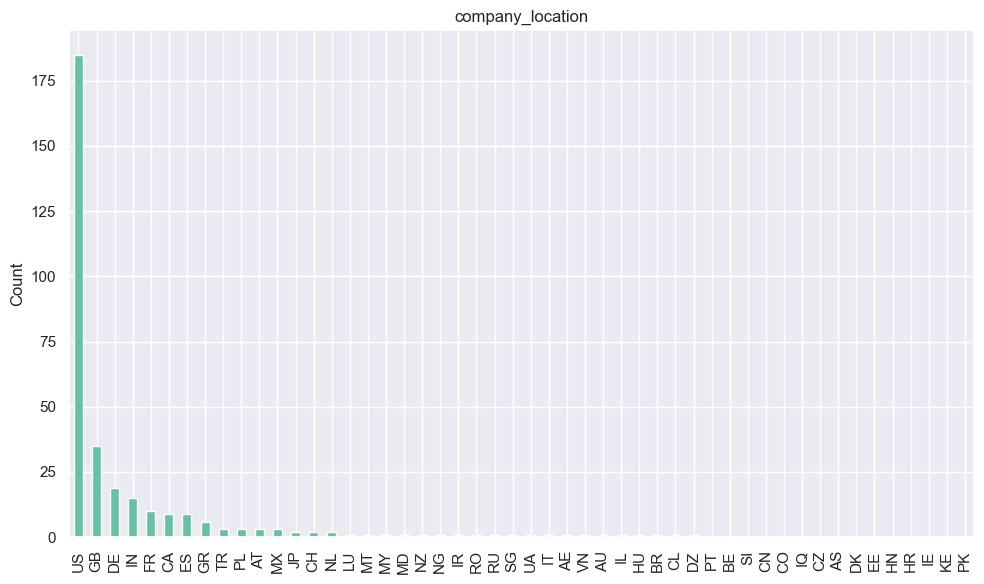

In [12]:
# График распределения для company_location
plt.figure(figsize=(10, 6))
data['company_location'].value_counts().plot(kind='bar')
plt.title('company_location')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

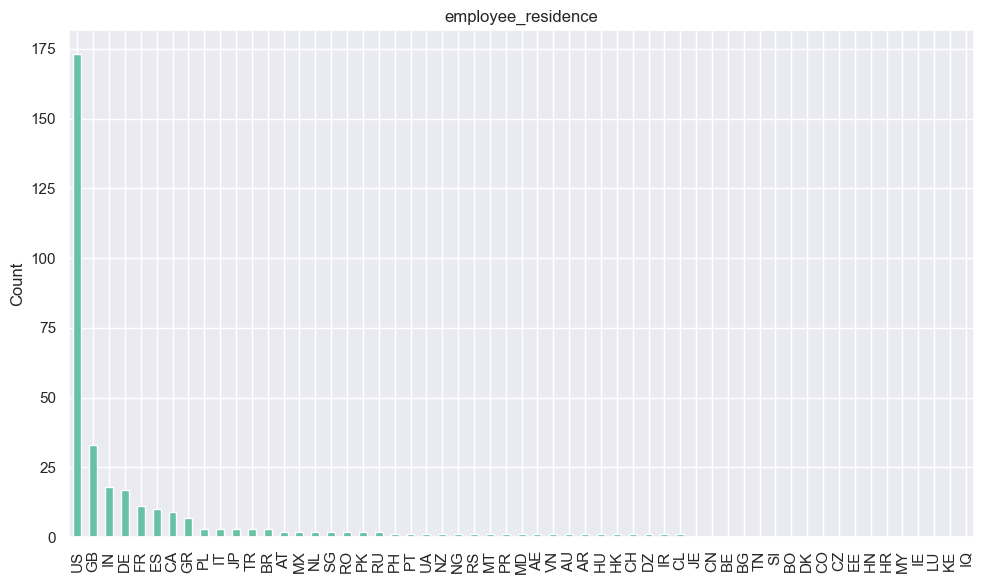

In [13]:
# График распределения для employee_residence
plt.figure(figsize=(10, 6))
data['employee_residence'].value_counts().plot(kind='bar')
plt.title('employee_residence')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Самые часто встречаемые страны в 'company_location' и 'employee_residence' являются: US, GB, IN, DE, FR, ES, CA, GR. Все остальные страны сгруппируем в "Other".

In [14]:
# Создание признака 'company_location_clean', 'employee_residence_clean'
main_countries = ['US', 'GB', 'IN', 'DE', 'FR', 'ES', 'CA', 'GR']
data['company_location_clean'] = data['company_location'].apply(lambda x: x if x in main_countries else 'Other')
data['employee_residence_clean'] = data['employee_residence'].apply(lambda x: x if x in main_countries else 'Other')

# удалим ненужные признаки 'company_location', 'employee_residence'
data = data.drop(['company_location', 'employee_residence'], axis=1)

## <center> 2.1. Визуальный анализ данных

Взглянем на распределение **"salary_in_usd"** по отдельности по **data_scientist** и по **data_engineer**

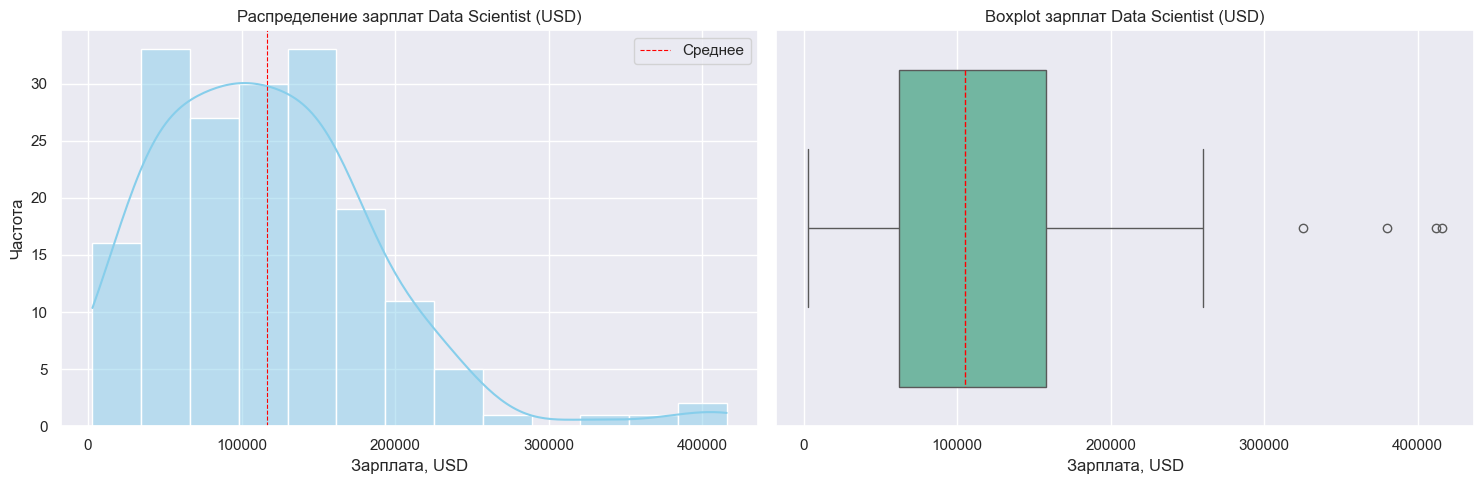

In [15]:
# Гистограмма и boxplot зарплат (USD) для Data Scientist
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data[data['is_data_scientist']]['salary_in_usd'], kde=True, ax=axes[0], color='skyblue')
axes[0].set(xlabel='Зарплата, USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат Data Scientist (USD)')
axes[0].axvline(data[data['is_data_scientist']]['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='Среднее')
axes[0].legend()
sns.boxplot(x=data[data['is_data_scientist']]['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата, USD')
axes[1].set_title('Boxplot зарплат Data Scientist (USD)')
plt.tight_layout()
plt.show()

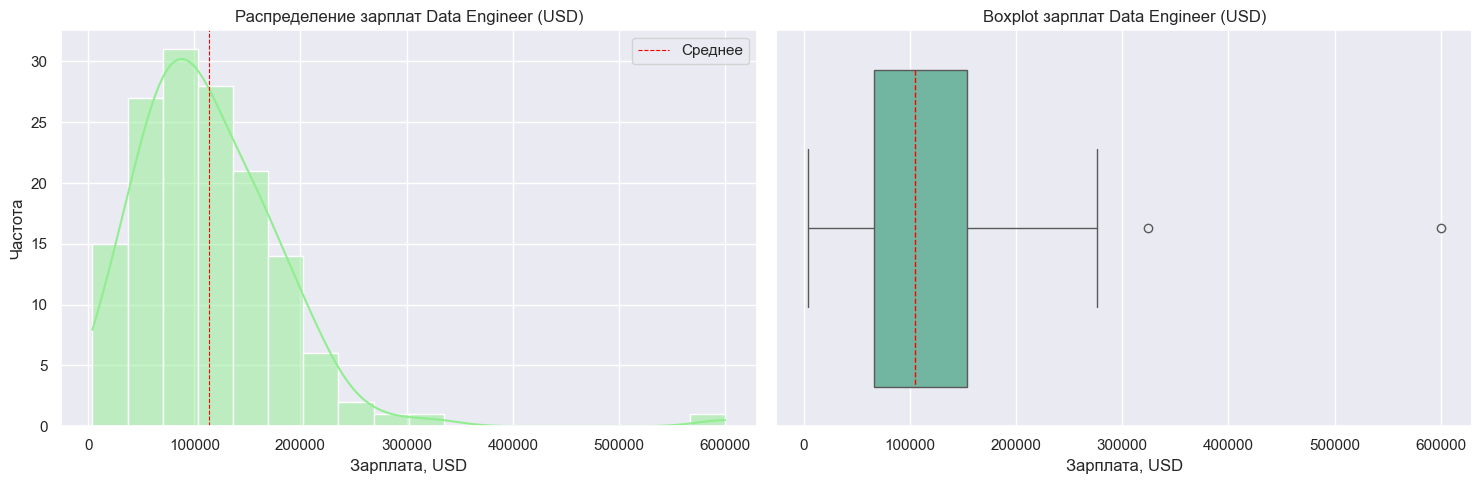

In [16]:
# Гистограмма и boxplot зарплат (USD) для Data Engineer
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data[data['is_data_engineer']]['salary_in_usd'], kde=True, ax=axes[0], color='lightgreen')
axes[0].set(xlabel='Зарплата, USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат Data Engineer (USD)')
axes[0].axvline(data[data['is_data_engineer']]['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='Среднее')
axes[0].legend()
sns.boxplot(x=data[data['is_data_engineer']]['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата, USD')
axes[1].set_title('Boxplot зарплат Data Engineer (USD)')
plt.tight_layout()
plt.show()

In [17]:
data_agg = data.groupby('is_data_scientist')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от должности')
data_agg

Заработные платы в зависимости от должности


,count,mean,std,min,25%,50%,75%,max
is_data_scientist,,,,,,,,
False,147.0,113590.47,71848.71,4000.0,65985.5,104702.0,153500.0,600000.0
True,179.0,116396.41,72362.48,2859.0,62096.5,105000.0,157600.0,416000.0


На первый взгляд заработные платы для Data Scientist и Data Engineer вполне сопоставимы (минимальные различия), но количество позиций все же больше по специальности Data Scientist

Проверим потенциальные выбросы с заработной платой свыше 300тыс долларов, на предмет действительности. (предварительно, это вакансии для специалистов высокой квалификации "Principal/Director" (SE — Senior-level Expert/ EX — Executive-level Director), удалят их не станем

In [18]:
high_salary = data[data['salary_in_usd'] > 300000]
high_salary

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_size,is_data_scientist,is_data_engineer,company_location_clean,employee_residence_clean
14,2020,EX,FT,Director of Data Science,325000,100,L,True,False,US,US
38,2020,SE,FT,Data Scientist,412000,100,L,True,False,US,US
126,2021,EX,CT,Principal Data Scientist,416000,100,S,True,False,US,US
145,2021,EX,FT,Principal Data Engineer,600000,100,L,False,True,US,US
274,2022,EX,FT,Data Engineer,324000,100,M,False,True,US,US
294,2022,SE,FT,Applied Data Scientist,380000,100,L,True,False,US,US


Далее изучим категориальные признаки по обоим группам и "Графически" сравним их

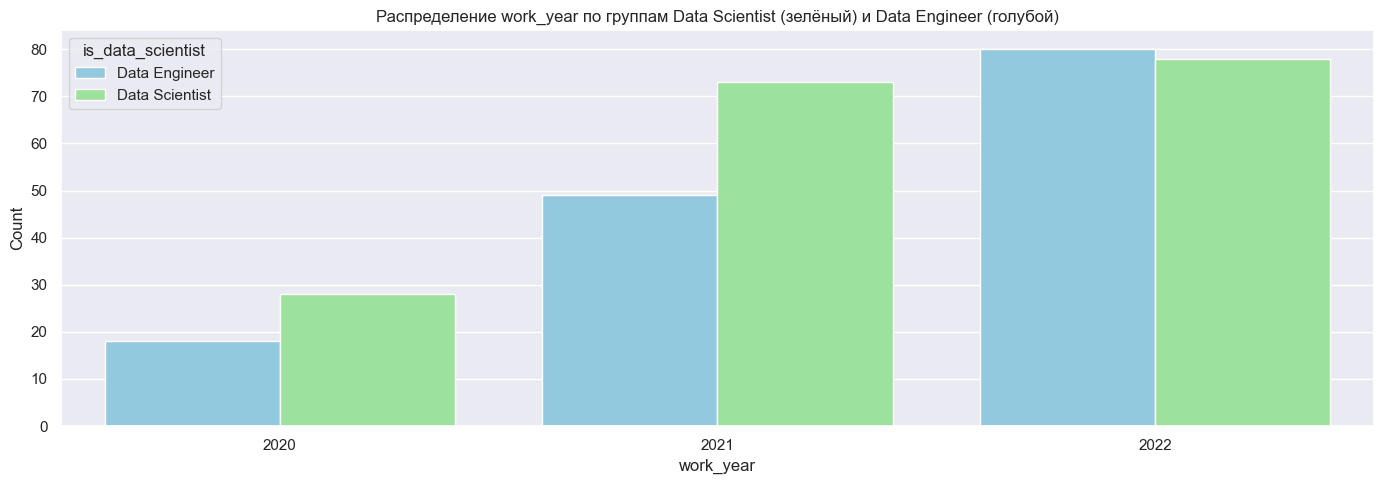

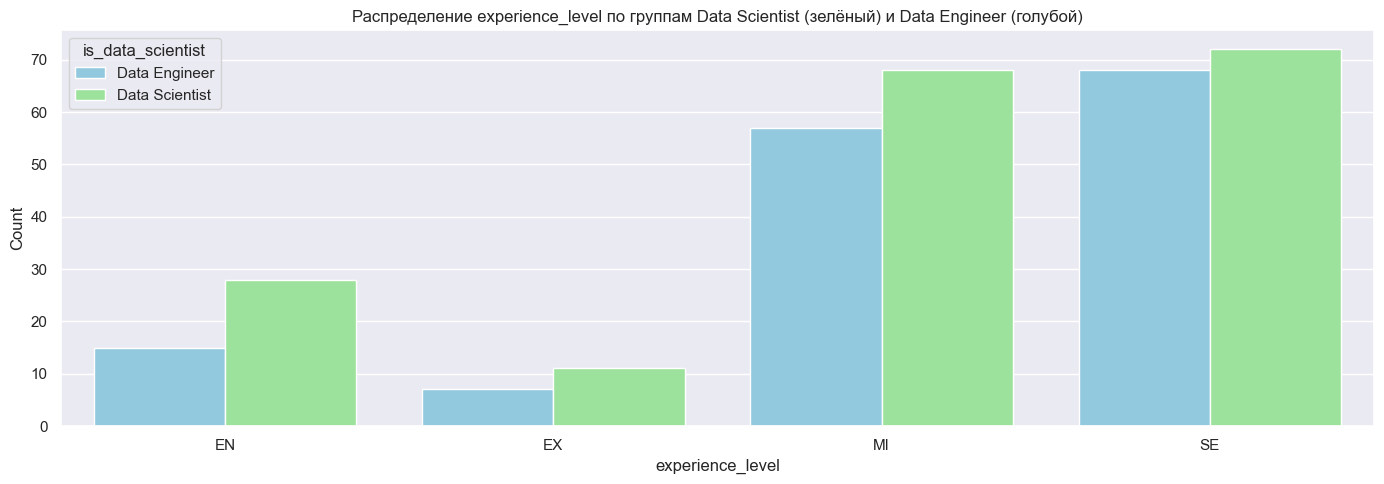

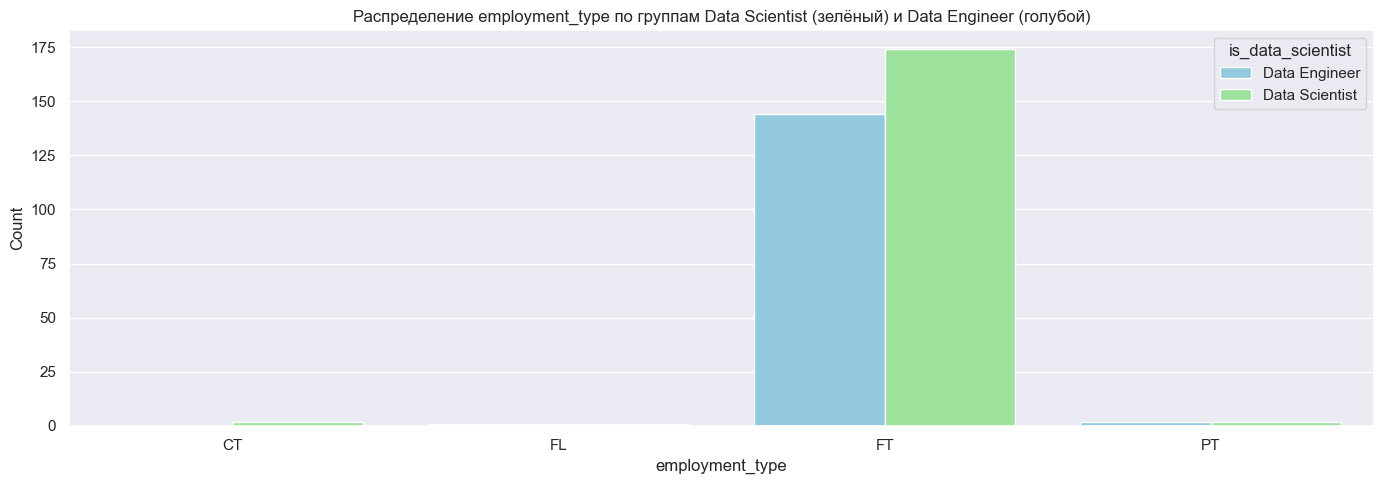

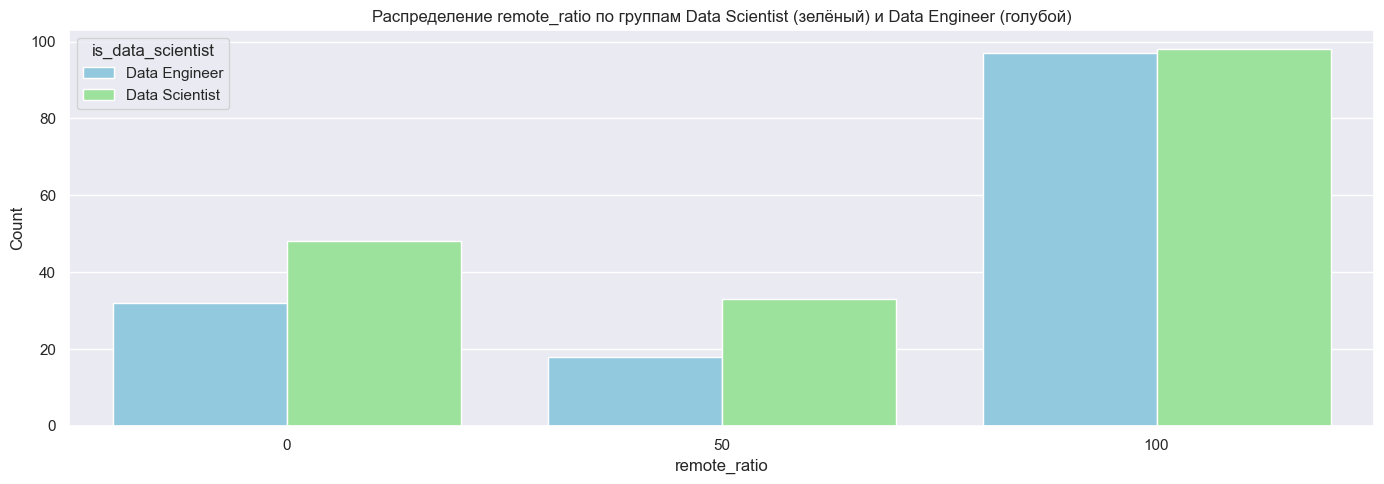

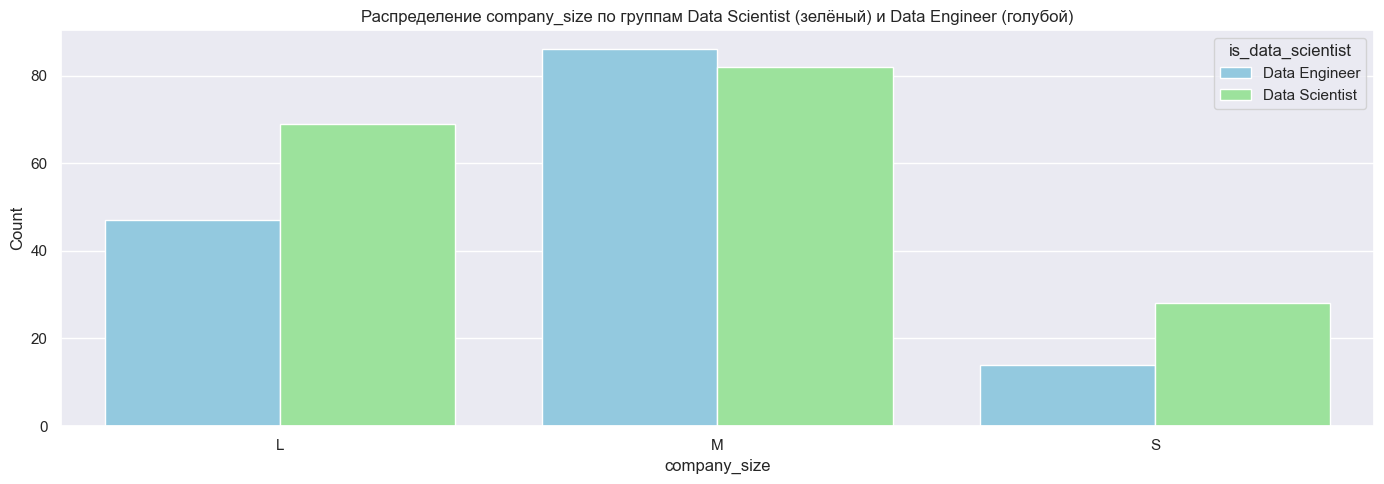

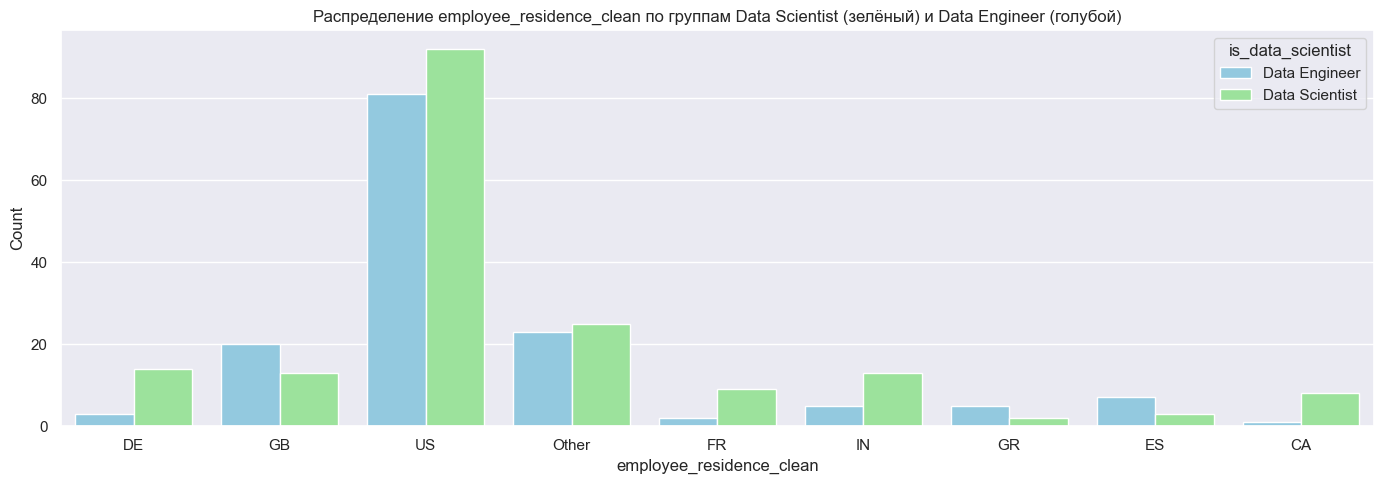

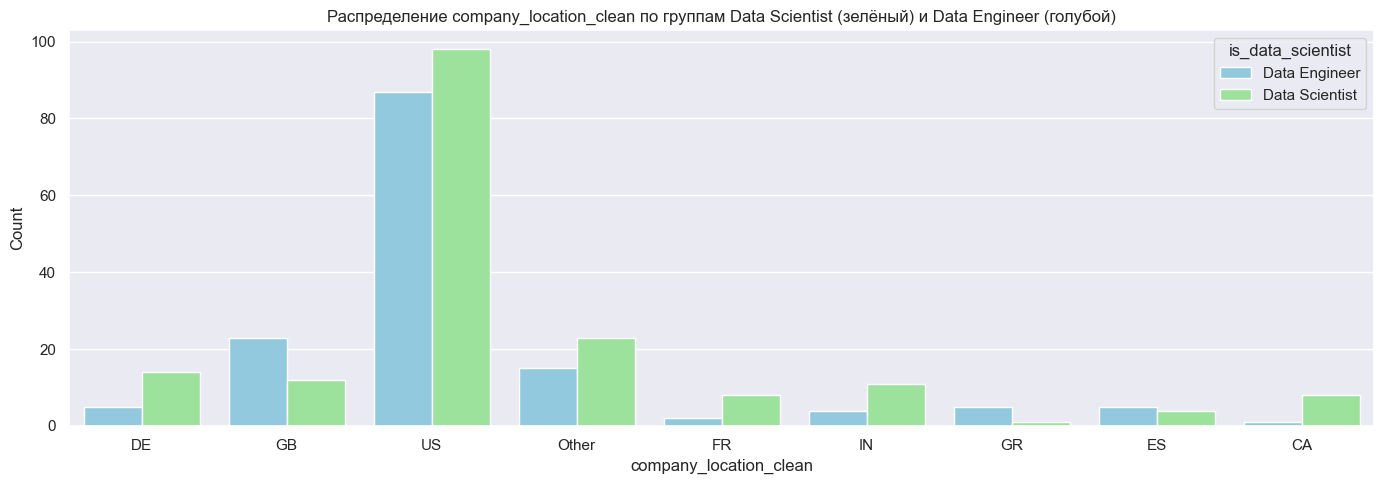

In [19]:
# Сравнительные barplot для категориальных признаков по группам Data Scientist и Data Engineer
categorical_cols = ['work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_size', 'employee_residence_clean', 'company_location_clean']
for col in categorical_cols:
    plt.figure(figsize=(14, 5))
    sns.countplot(data=data, x=col, hue='is_data_scientist', palette=['skyblue', 'lightgreen'])
    plt.title(f'Распределение {col} по группам Data Scientist (зелёный) и Data Engineer (голубой)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='is_data_scientist', labels=['Data Engineer', 'Data Scientist'])
    plt.tight_layout()
    plt.show()

Воспользуемся Ydata-profiling для быстрого анализа данных, убедиться что ничего не упустил

In [20]:
from ydata_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 463.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Рассмотрим влияние каждого из признаков, участвующих в исследовании, на зарплату по всем наименованиям Data Scientist и сравним их с Data Engineer. И сделаю предварительные выводы.

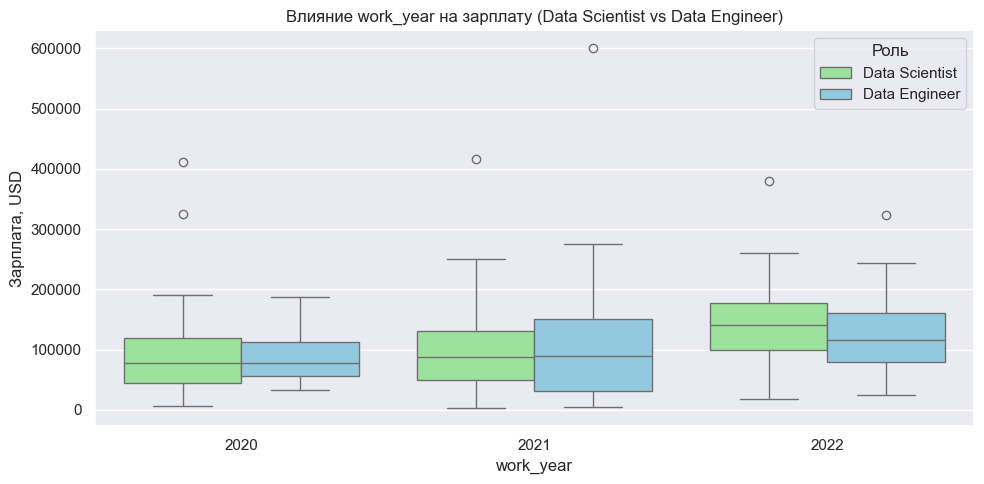

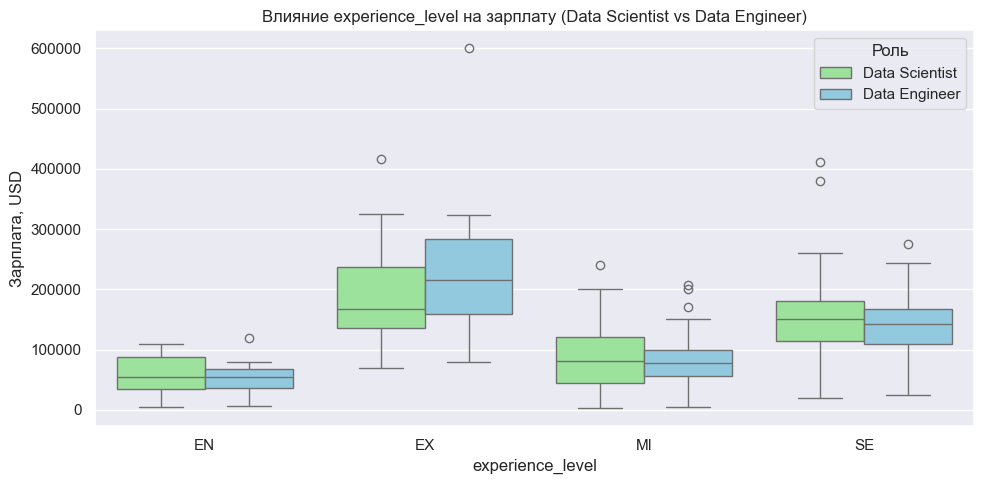

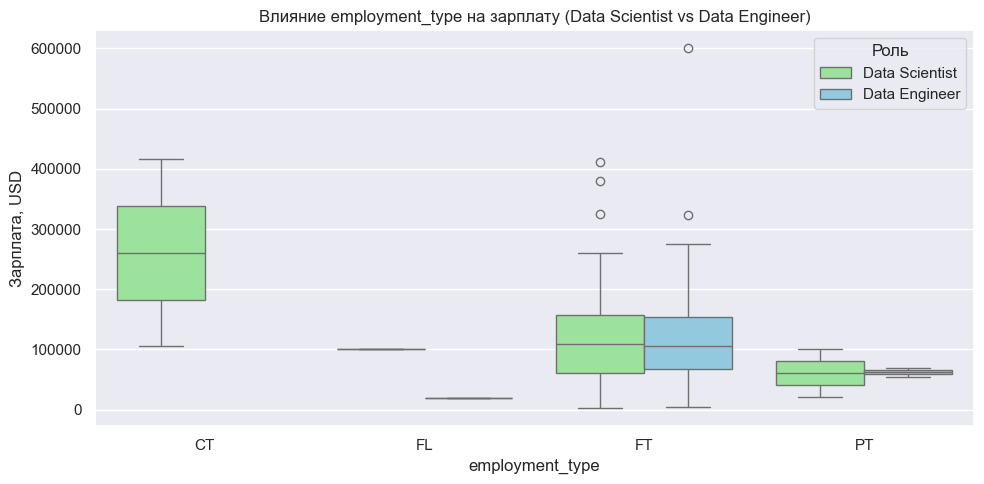

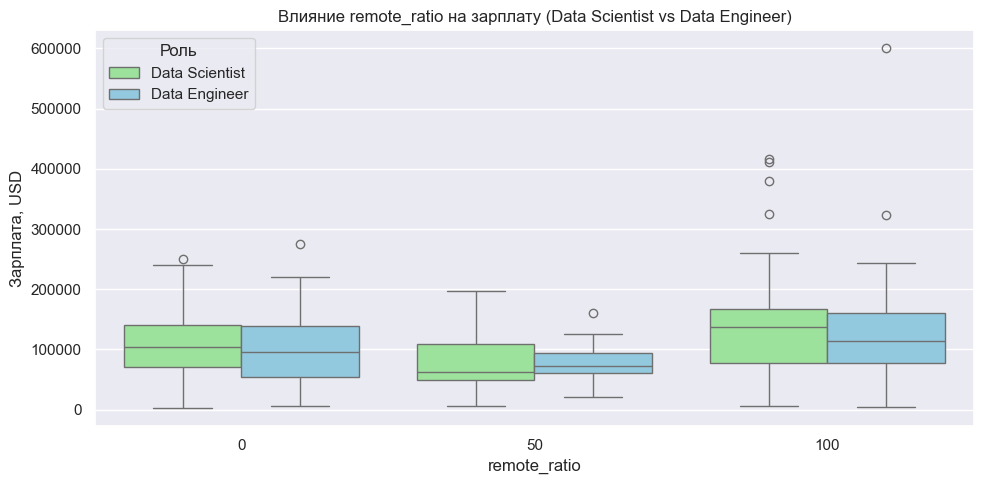

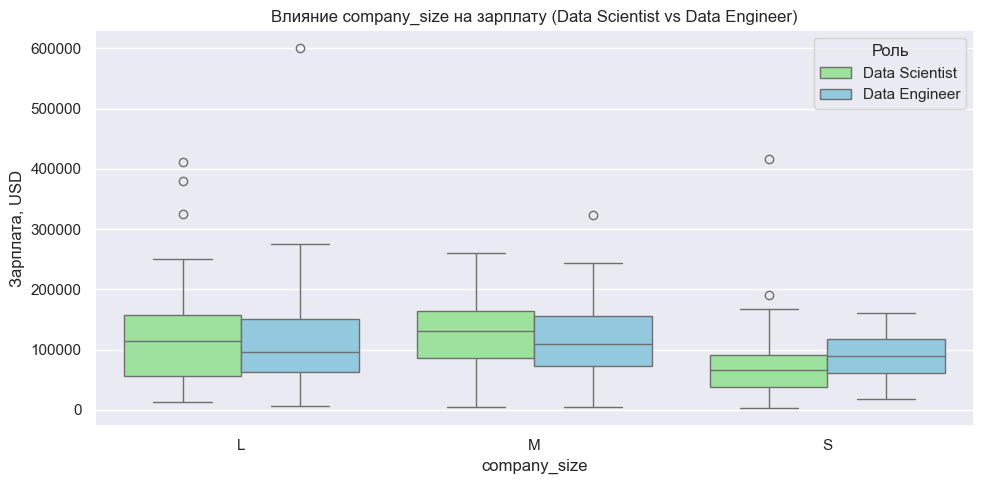

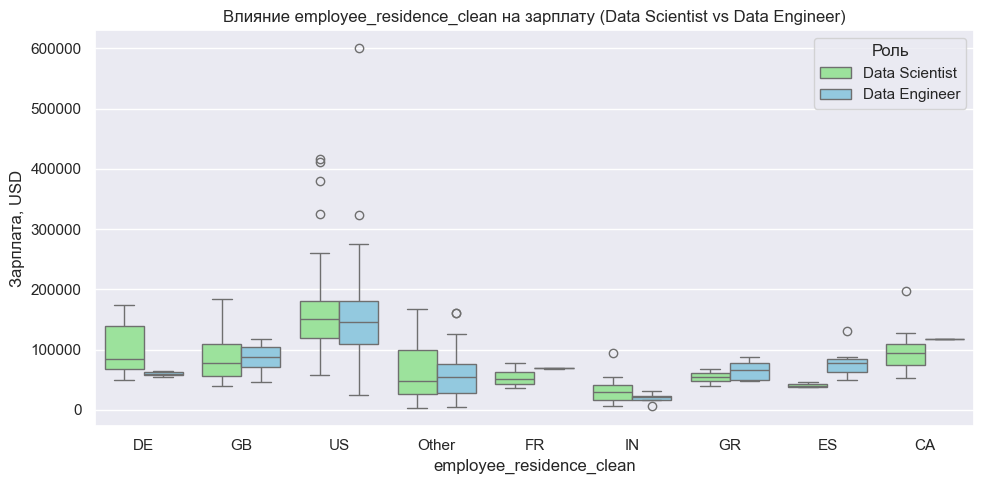

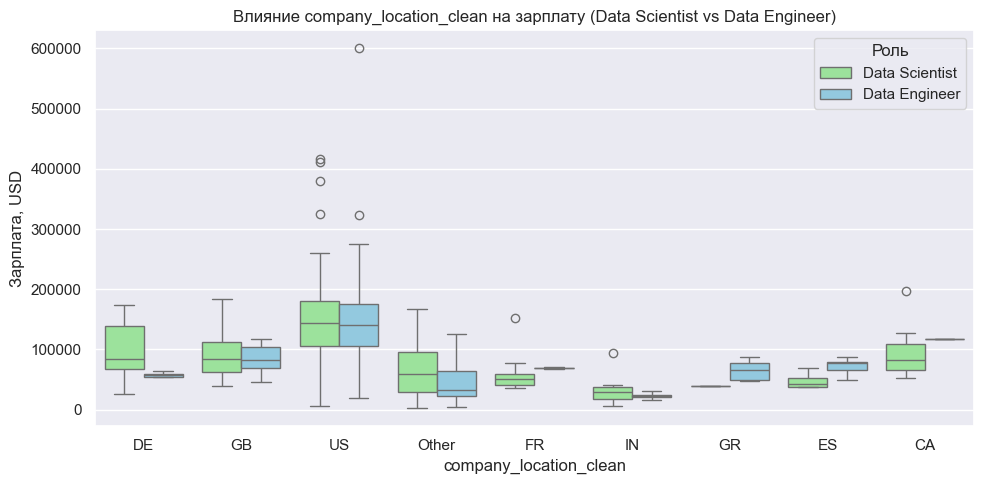

In [21]:
# Сравнение влияния признаков на зарплату Data Scientist и Data Engineer
compare = data[data['is_data_scientist'] | data['is_data_engineer']].copy()
compare['role'] = compare['is_data_scientist'].map({True: 'Data Scientist', False: 'Data Engineer'})
features = ['work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_size', 'employee_residence_clean', 'company_location_clean']
for col in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='salary_in_usd', hue='role', data=compare, palette={'Data Scientist': 'lightgreen', 'Data Engineer': 'skyblue'})
    plt.title(f'Влияние {col} на зарплату (Data Scientist vs Data Engineer)')
    plt.ylabel('Зарплата, USD')
    plt.xlabel(col)
    plt.legend(title='Роль')
    plt.tight_layout()
    plt.show()

### **Предварительные выводы (на основе графиков):**

Факторы, которые влияют на заработную плату **Data Scientist**:

- Год работы (work_year): наблюдается рост зарплат с каждым годом.
- Уровень опыта (experience_level): Senior и Executive получают значительно больше, чем Junior.
- Тип занятости (employment_type): Full-time обычно выше, чем part-time и другие.
- Доля удалённой работы (remote_ratio): полностью удалённые позиции часто имеют более высокие зарплаты.
- Размер компании (company_size): средняя зарплата в средних и больших компаниях выше, чем в малых.
- Страна работодателя (company_location_clean): зарплаты в США, Великобритании и Канаде выше, чем в других странах.
- Страна проживания сотрудника (employee_residence_clean): аналогично, резиденты развитых стран получают больше.

Наиболее сильное влияние оказывают уровень опыта, страна работодателя и размер компании.

Сравнивая **Data Scientist** и **Data Engineer** по визуализациям и статистике, можно сделать следующие выводы:

- Средние зарплаты у Data Scientist и Data Engineer сопоставимы, но у Data Scientist чуть больше вакансий с высокими зарплатами.
- Для обеих ролей уровень опыта (особенно Senior/Executive) — главный фактор роста зарплаты.
- В крупных компаниях и в развитых странах (US, GB, CA, DE) зарплаты выше для обеих ролей, но разница между странами для Data Engineer выражена сильнее.
- Доля удалённой работы положительно влияет на зарплату обеих ролей, но у Data Scientist полностью удалённые позиции встречаются чаще.
- По типу занятости (employment_type) и размеру компании различий между ролями немного: обе группы получают больше на full-time и в крупных компаниях.
- Распределение по годам (work_year) показывает общий рост зарплат в обеих группах, но у Data Scientist рост более выражен.

В целом, различия между ролями невелики, но Data Scientist чаще встречаются в высокооплачиваемых и удалённых позициях, а у Data Engineer сильнее выражена зависимость зарплаты от страны и размера компании.

# <center> 2.2. Статистический анализ данных

Вспомним какие безнес вопросы перед нами стоят, ключевые вопросы HR-агентства:

1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - нулевая гипотеза **роста зарплат Data Scientist не наблюдается**
    - альтернативная гипотеза **наблюдается роста зарплат Data Scientist**

2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - нулевая гипотеза **разница зарплат между специалистами Data Scientist и Data Engineer в 2022 году отсутствует**
    - альтернативная гипотеза **наблюдается разница зарплат между специалистами Data Scientist и Data Engineer в 2022 году**

3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - нулевая гипотеза **разница зарплат Data Scientist не зависит от размера компании**
    - альтернативная гипотеза **наблюдается разница зарплат Data Scientist от размера компании**
    
4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
    - нулевая гипотеза **наличие должностей не зависит от размера компании**
    - альтернативная гипотеза **наблюдается зависимость количества должностей от размера компании**

### Приступим к проверке Вопрос #1:

1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - нулевая гипотеза **роста зарплат Data Scientist не наблюдается**
    - альтернативная гипотеза **наблюдается рост зарплат Data Scientist**

In [22]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_disp_check = data.loc[(data['is_data_scientist'] == True), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')
    

p-value = 0.000
Распределение не нормальное


Выбираем **Критерий Фридамана** (3 зависимые группы; распределение не нормальное)

In [23]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_2020 = data.loc[(data['is_data_scientist'] == True) & (data['work_year'] == 2020), 'salary_in_usd']
data_2021 = data.loc[(data['is_data_scientist'] == True) & (data['work_year'] == 2021), 'salary_in_usd']
data_2022 = data.loc[(data['is_data_scientist'] == True) & (data['work_year'] == 2022), 'salary_in_usd']

# проводим тест
min_len = min(len(data_2020), len(data_2021), len(data_2022)) # необходимо привести df к единой длинне по годам 2020, 2021, 2022
_, p = stats.friedmanchisquare(data_2020[:min_len], data_2021[:min_len], data_2022[:min_len])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** Принимаем альтернитивную гипотезу: **наблюдается рост зарплат Data Scientist** за 2020, 2021, 2022 год

### Вопрос #2:

2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - нулевая гипотеза **разница зарплат между специалистами Data Scientist и Data Engineer в 2022 году отсутствует**
    - альтернативная гипотеза **наблюдается разница зарплат между специалистами Data Scientist и Data Engineer в 2022 году**

In [24]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_disp_check = data.loc[(data['is_data_scientist'] == True) & (data['work_year'] == 2022), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')
    

p-value = 0.038
Распределение не нормальное


In [25]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Engineer
data_disp_check = data.loc[(data['is_data_engineer'] == True) & (data['work_year'] == 2022), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')
    

p-value = 0.007
Распределение не нормальное


Выбираем **U Критерий Манна-Уитни** (2 независимые группы; распределение не нормальное)

In [26]:
# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data_DS_2022 = data.loc[(data['is_data_scientist'] == True) & (data['work_year'] == 2022), 'salary_in_usd']
data_DE_2022 = data.loc[(data['is_data_engineer'] == True) & (data['work_year'] == 2022), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_DS_2022, data_DE_2022)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
    

p-value = 0.069
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


На графиках мы видели небольшую разницу в ЗП за 2022 и сделали предварительный вывод в пользу большей ЗП у Data Scientist:
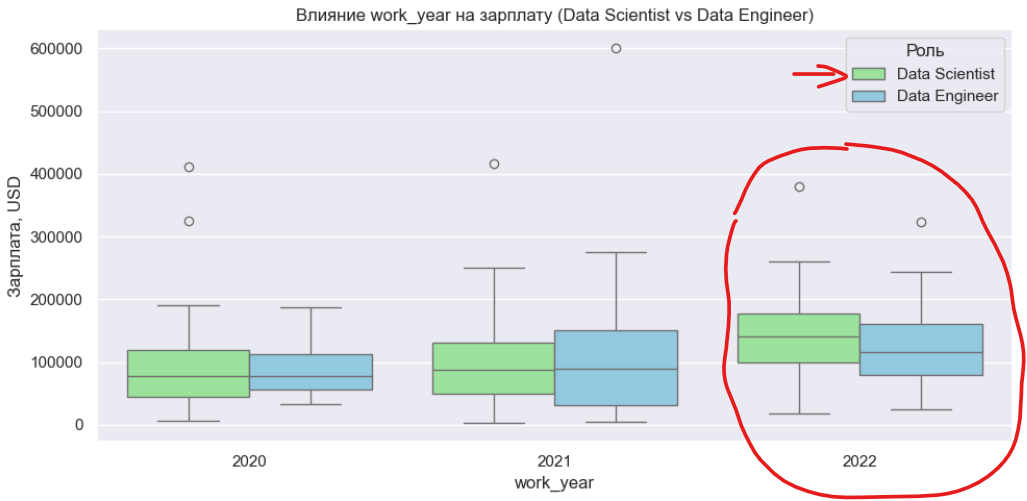

**Вывод:** Однако, у нас нет оснований опровергать нулевую теорию и принимаем нулевую гипотезу **разница зарплат между специалистами Data Scientist и Data Engineer в 2022 году отсутствует** (при данной уровне значимости 0.05, значение p-value очень близко к пороговому)

### Вопрос #3
3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - нулевая гипотеза **разница зарплат Data Scientist не зависит от размера компании**
    - альтернативная гипотеза **наблюдается разница зарплат Data Scientist от размера компании**

In [27]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_disp_check = data.loc[(data['is_data_scientist'] == True) & (data['company_size'] == 'L'), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')
    

p-value = 0.000
Распределение не нормальное


Выбираем **Критерий Краскела-Уоллиса** (3 независимые группы; распределение не нормальное)

In [28]:
# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data_company_S = data.loc[(data['is_data_scientist'] == True) & (data['company_size'] == 'S'), 'salary_in_usd']
data_company_M = data.loc[(data['is_data_scientist'] == True) & (data['company_size'] == 'M'), 'salary_in_usd']
data_company_L = data.loc[(data['is_data_scientist'] == True) & (data['company_size'] == 'L'), 'salary_in_usd']

# проводим тест
_, p = stats.kruskal(data_company_S, data_company_M, data_company_L)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


На графиках мы видели что зарплата в средних и больших компаниях выше, чем в малых. Но отличается не значительно если сравнивать только между большими и средними компаниями
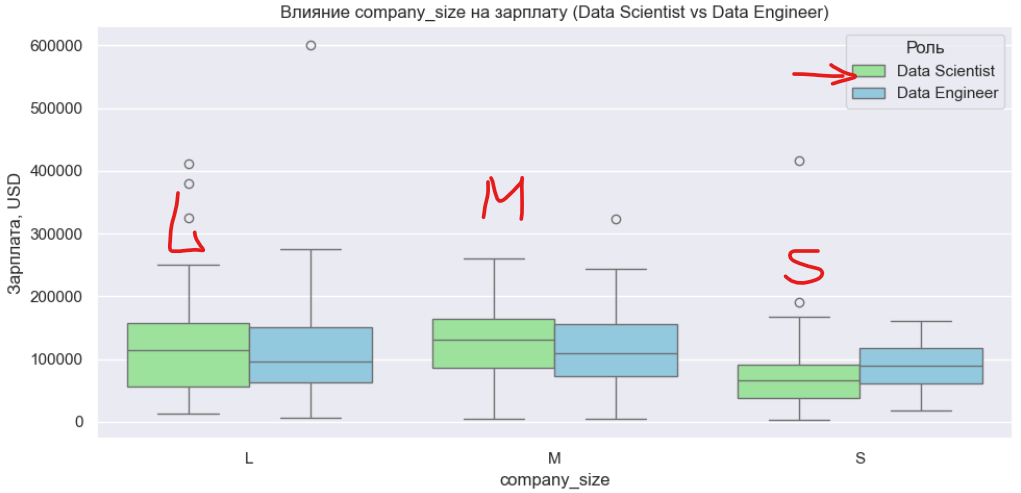

**Вывод:** Статистический анализ подтверил, принимаем альтернативную гипотезу **разница зарплат Data Scientist зависит от размера компании** 

### Вопрос #4 

4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
    - нулевая гипотеза **наличие должностей не зависит от размера компании**
    - альтернативная гипотеза **наблюдается зависимость количества должностей от размера компании**

КРИТЕРИЙ ХИ-КВАДРАТ

для определения связи между двумя категориальными переменными (Company Size vs. Data Scientist/Data Engineer positions)

In [29]:
# вычисляем таблицу сопряжённости
table = pd.crosstab(data['company_size'], data['is_data_scientist'])
table

is_data_scientist,False,True
company_size,,
L,47,69
M,86,82
S,14,28


In [30]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



p-value = 0.054
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** глядя на таблицу сопряжённости и результат  критерий ХИ Квадрат, у нас нет оснований полагать что количество позиций в компаниях зависит от их размера. Принимаем нулевую гипотезу **наличие должностей не зависит от размера компании** (но очень близко к пороговому значению уровня значимости 0.05)

# <center> 4. Дополнительное исследование 

Две дополнительных бизнес-гипотезы о влиянии факторов на заработную плату специалистов:

5. Уровень опыта (experience_level): Senior и Executive получают значительно больше, чем Junior.
    - нулевая гипотеза **уровень опыта не влияет на заработную плату**
    - альтернативная гипотеза **уровень опыта влияет на заработную плату**
6. Страна работодателя (company_location_clean): зарплаты в США выше, чем в других странах.
    - нулевая гипотеза **страна работодятеля не влияет на заработные платы**
    - альтернативная гипотеза **страна работодателя влияет на заработные платы**

### Вопрос #5
5. Уровень опыта (experience_level): Senior и Executive получают значительно больше, чем Junior.
    - нулевая гипотеза **уровень опыта не влияет на заработную плату**
    - альтернативная гипотеза **уровень опыта влияет на заработную плату**

Опыт работы на этой должности в течение года со следующими возможными значениями:
- EN — Entry-level/Junior;
- MI — Mid-level/Intermediate;
- SE — Senior-level/Expert;
- EX — Executive-level/Director.

In [31]:
# загружаем данные
data_exp_EN = data.loc[(data['is_data_scientist'] == True) & (data['experience_level'] == 'EN'), 'salary_in_usd']
data_exp_MI = data.loc[(data['is_data_scientist'] == True) & (data['experience_level'] == 'MI'), 'salary_in_usd']
data_exp_SE = data.loc[(data['is_data_scientist'] == True) & (data['experience_level'] == 'SE'), 'salary_in_usd']
data_exp_EX = data.loc[(data['is_data_scientist'] == True) & (data['experience_level'] == 'EX'), 'salary_in_usd']

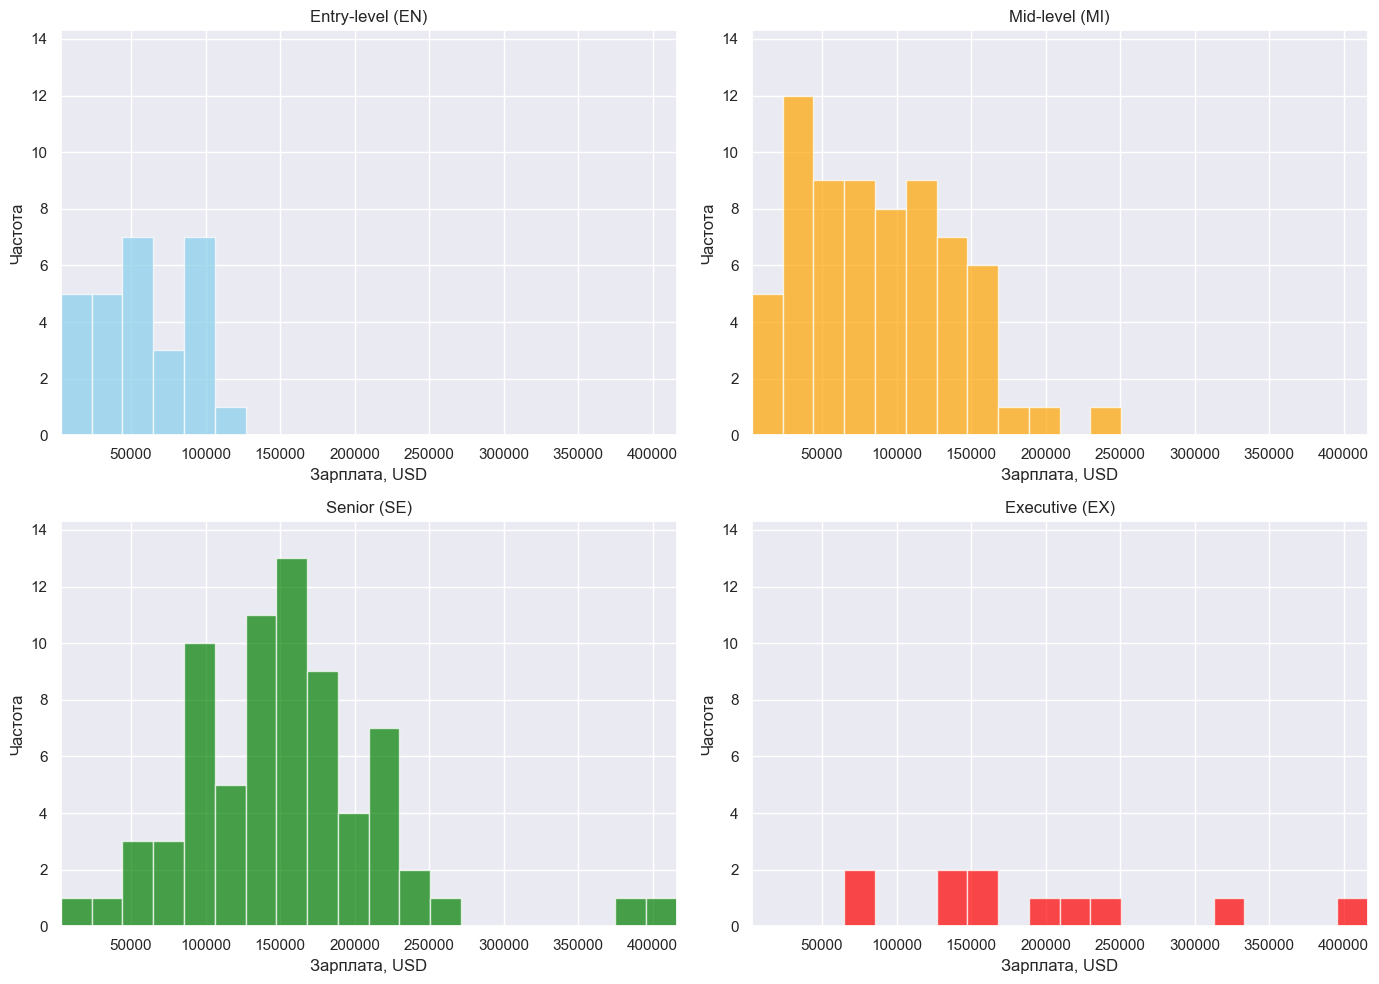

In [32]:
# Отдельные гистограммы зарплат Data Scientist по уровням опыта (единый масштаб осей)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
# Определяем общий диапазон для оси X и максимальную частоту для оси Y
all_salaries = pd.concat([data_exp_EN, data_exp_MI, data_exp_SE, data_exp_EX])
x_min = all_salaries.min()
x_max = all_salaries.max()
# Для Y: находим максимальную частоту среди всех гистограмм
hist_EN = np.histogram(data_exp_EN, bins=20, range=(x_min, x_max))[0]
hist_MI = np.histogram(data_exp_MI, bins=20, range=(x_min, x_max))[0]
hist_SE = np.histogram(data_exp_SE, bins=20, range=(x_min, x_max))[0]
hist_EX = np.histogram(data_exp_EX, bins=20, range=(x_min, x_max))[0]
y_max = max(hist_EN.max(), hist_MI.max(), hist_SE.max(), hist_EX.max()) * 1.1
axes[0].hist(data_exp_EN, bins=20, color='skyblue', alpha=0.7, range=(x_min, x_max))
axes[0].set_title('Entry-level (EN)')
axes[0].set_xlabel('Зарплата, USD')
axes[0].set_ylabel('Частота')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(0, y_max)
axes[1].hist(data_exp_MI, bins=20, color='orange', alpha=0.7, range=(x_min, x_max))
axes[1].set_title('Mid-level (MI)')
axes[1].set_xlabel('Зарплата, USD')
axes[1].set_ylabel('Частота')
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(0, y_max)
axes[2].hist(data_exp_SE, bins=20, color='green', alpha=0.7, range=(x_min, x_max))
axes[2].set_title('Senior (SE)')
axes[2].set_xlabel('Зарплата, USD')
axes[2].set_ylabel('Частота')
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(0, y_max)
axes[3].hist(data_exp_EX, bins=20, color='red', alpha=0.7, range=(x_min, x_max))
axes[3].set_title('Executive (EX)')
axes[3].set_xlabel('Зарплата, USD')
axes[3].set_ylabel('Частота')
axes[3].set_xlim(x_min, x_max)
axes[3].set_ylim(0, y_max)
plt.tight_layout()
plt.show()

C:\Users\tgorbunov\AppData\Local\Temp\ipykernel_18772\2418024986.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_exp_EN, data_exp_MI, data_exp_SE, data_exp_EX],


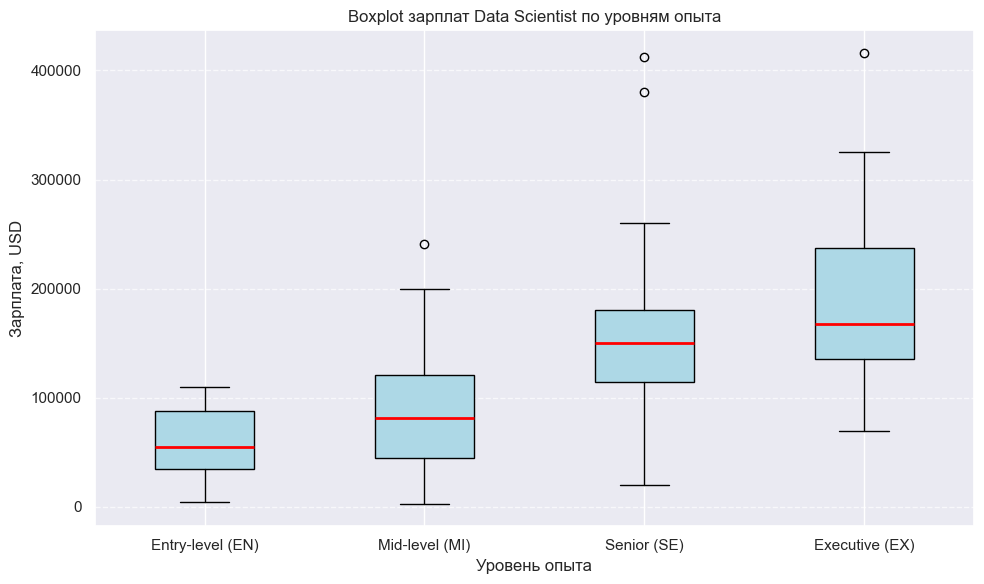

In [33]:
# Boxplot (диаграмма с усами) зарплат Data Scientist по уровням опыта
plt.figure(figsize=(10, 6))
plt.boxplot([data_exp_EN, data_exp_MI, data_exp_SE, data_exp_EX],
            labels=['Entry-level (EN)', 'Mid-level (MI)', 'Senior (SE)', 'Executive (EX)'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red', linewidth=2))
plt.xlabel('Уровень опыта')
plt.ylabel('Зарплата, USD')
plt.title('Boxplot зарплат Data Scientist по уровням опыта')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

По графикам гистограмм и бокс диаграмм очевидна разница в значениях ЗП в зависимости от опыта, проверим это статистически

EN — Entry-level/Junior;

In [34]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_disp_check = data.loc[data['is_data_scientist'] == True & (data['experience_level'] == 'EN'), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


SE — Senior-level/Expert;

In [35]:
# задаём уровень значимости
alpha = 0.05 

# фильтруем только Data Scientist
data_disp_check = data.loc[data['is_data_scientist'] == True & (data['experience_level'] == 'SE'), 'salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_disp_check)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


Выбираем **Критерий Краскела-Уоллиса** (4 независимые группы; распределение не нормальное)

In [41]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
min_len = min(len(data_exp_EN), len(data_exp_MI), len(data_exp_SE), len(data_exp_EX)) # необходимо привести df к единой длинне по годам 2020, 2021, 2022
_, p = stats.friedmanchisquare(data_exp_EN[:min_len], data_exp_MI[:min_len], data_exp_SE[:min_len], data_exp_EX[:min_len])

# проводим тест
_, p = stats.kruskal(data_exp_EN, data_exp_SE, data_exp_EX)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** Принимаем альтернативную гипотезу, уровень ЗП зависит от опыта сотрудника (подтверждено на графиках и статистическим анализом)

### Вопрос #6
6. Страна работодателя (company_location): зарплаты в США выше чем в остальном мире
    - нулевая гипотеза **страна работодятеля не влияет на заработные платы**
    - альтернативная гипотеза **страна работодателя влияет на заработные платы**

In [42]:
# загружаем данные
data['is_US'] = data['company_location_clean'] == 'US'

data_country_is_US = data.loc[(data['is_data_scientist'] == True) & (data['is_US'] == True), 'salary_in_usd']
data_country_is_NOT_US = data.loc[(data['is_data_scientist'] == True) & (data['is_US'] == False), 'salary_in_usd']

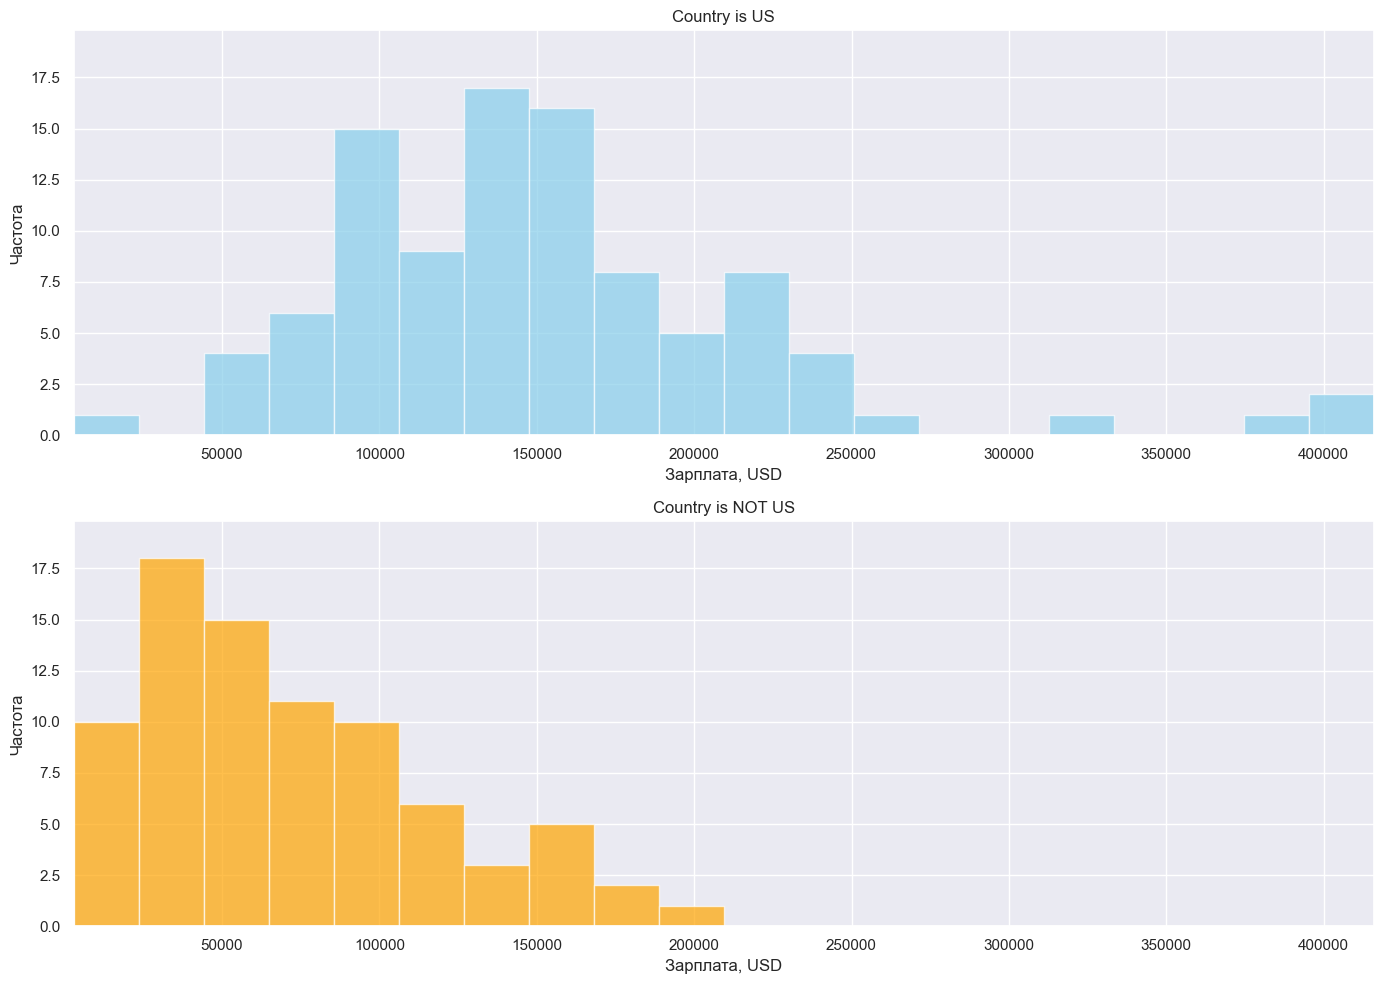

In [43]:
# Отдельные гистограммы зарплат Data Scientist по уровням опыта (единый масштаб осей)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
axes = axes.flatten()
# Определяем общий диапазон для оси X и максимальную частоту для оси Y
all_salaries = pd.concat([data_exp_EN, data_exp_MI, data_exp_SE, data_exp_EX])
x_min = all_salaries.min()
x_max = all_salaries.max()
# Для Y: находим максимальную частоту среди всех гистограмм
hist_US = np.histogram(data_country_is_US, bins=20, range=(x_min, x_max))[0]
hist_not_US = np.histogram(data_country_is_NOT_US, bins=20, range=(x_min, x_max))[0]

y_max = max(hist_US.max(), hist_not_US.max()) * 1.1
axes[0].hist(data_country_is_US, bins=20, color='skyblue', alpha=0.7, range=(x_min, x_max))
axes[0].set_title('Country is US')
axes[0].set_xlabel('Зарплата, USD')
axes[0].set_ylabel('Частота')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(0, y_max)
axes[1].hist(data_country_is_NOT_US, bins=20, color='orange', alpha=0.7, range=(x_min, x_max))
axes[1].set_title('Country is NOT US')
axes[1].set_xlabel('Зарплата, USD')
axes[1].set_ylabel('Частота')
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

По графикам гистограмм очевидна разница в значениях ЗП в США и других странах мира, проверим это статистически

In [44]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_country_is_US)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


Выбираем **U Критерий Манна-Уитни** (2 независимые группы; распределение не нормальное)

In [45]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.mannwhitneyu(data_country_is_US, data_country_is_NOT_US)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
    

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** Опровергаем нулевую теорию, действительно ЗП в США отличаются от ЗП в других странах